# Import Libraries

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm

!pip install torchmetrics
import torchmetrics

# Import Data

In [49]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [50]:
import os

# List files in the dataset directory
dataset_files = os.listdir(path)
print("Files in the dataset:", dataset_files)


Files in the dataset: ['hmnist_8_8_L.csv', 'ham10000_images_part_2', 'hmnist_28_28_RGB.csv', 'HAM10000_metadata.csv', 'ham10000_images_part_1', 'hmnist_28_28_L.csv', 'HAM10000_images_part_2', 'HAM10000_images_part_1', 'hmnist_8_8_RGB.csv']


# Viewing the Images

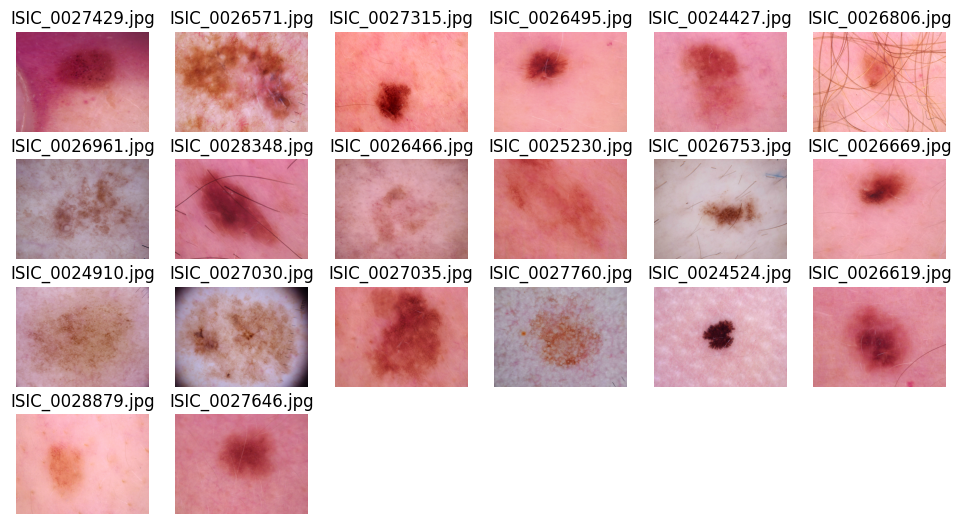

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display a few images
image_folder = os.path.join(path, "HAM10000_images_part_1")  # Adjust if necessary
sample_images = os.listdir(image_folder)[10:30]  # Show first 5 images

plt.figure(figsize=(12, 8))
for idx, img_file in enumerate(sample_images):
    img_path = os.path.join(image_folder, img_file)
    img = mpimg.imread(img_path)

    plt.subplot(5, 6, idx + 1)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis("off")

plt.show()

# Inspecting the size of the images

In [27]:
# This is to check if all the images are the same size
from PIL import Image
import os

# Path to your dataset folder
image_folder = os.path.join(path, "HAM10000_images_part_1") # Adjust if necessary
image_folder2 = os.path.join(path, "HAM10000_images_part_2") # Adjust if necessary

# To store sizes
image_sizes = set()
print(len(os.listdir(image_folder)))
print(len(os.listdir(image_folder2)))

# Loop through all files in the dataset
for image_file in os.listdir(image_folder):
    if image_file.endswith(('.jpg', '.jpeg', '.png')):  # adjust if necessary
        image_path = os.path.join(image_folder, image_file)  # Fixed the path here
        with Image.open(image_path) as img:
            image_sizes.add(img.size)  # Add the size to the set


# Check if all images have the same size
if len(image_sizes) == 1:
    print("All images have the same size:", image_sizes.pop())
else:
    print("Images have different sizes:", image_sizes)



5000
5015
All images have the same size: (600, 450)


In [ ]:
import cv2

In [ ]:
# Define the path to the image folder (adjust if needed based on output of previous step)
image_folder = os.path.join(path, "HAM10000_images_part_1")

# List the first few images in this folder
sample_images = os.listdir(image_folder)
print("Sample images:", sample_images[:5])

image_path = os.path.join(image_folder, sample_images[0])
# Load image and check dimensions
img = cv2.imread(image_path)
height, width, channels = img.shape
print("Image size:", (width, height))

Sample images: ['ISIC_0026029.jpg', 'ISIC_0024992.jpg', 'ISIC_0024541.jpg', 'ISIC_0024640.jpg', 'ISIC_0029067.jpg']
Image size: (600, 450)


# Exploratory Data Analysis

## Exploring the hmnist and meta data files

In [58]:
hmnist_file = os.path.join(path, "hmnist_28_28_RGB.csv")
data = pd.read_csv(hmnist_file)
data

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0


In [59]:
data.info()
data.columns
data.isnull().any().sum()
y = data['label']
x = data.drop(columns = ['label'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Columns: 2353 entries, pixel0000 to label
dtypes: int64(2353)
memory usage: 179.8 MB


At this point we can see that as we assumed there are 28 * 28 * 3 + 1 columns for all the 10015 data points. it's multiplied by three for each of RGB and the last col. is the label.
Labels are numbered from 0 to 6.

In [63]:
meta_data_file = os.path.join(path, "HAM10000_metadata.csv")
meta_data = pd.read_csv(meta_data_file)
meta_data

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [64]:
#classes = {'mel': 0 ,'vasc': 1,'df': 2,'nv': 3,'bkl': 4,'bcc': 5,'ak': 6}
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}


## Distribution of Sex

Text(0.5, 1.0, 'Distribution of Sex')

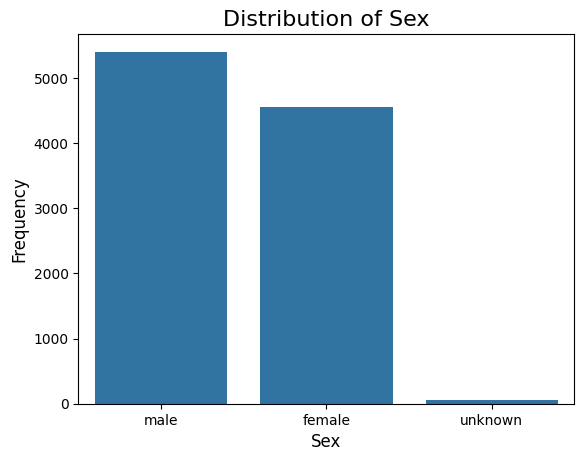

In [75]:
sns.countplot(x = 'sex', data = meta_data)
plt.xlabel('Sex', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Distribution of Sex', size=16)

## Distribution of Age

Text(0.5, 1.0, 'Histogram of Age of Patients')

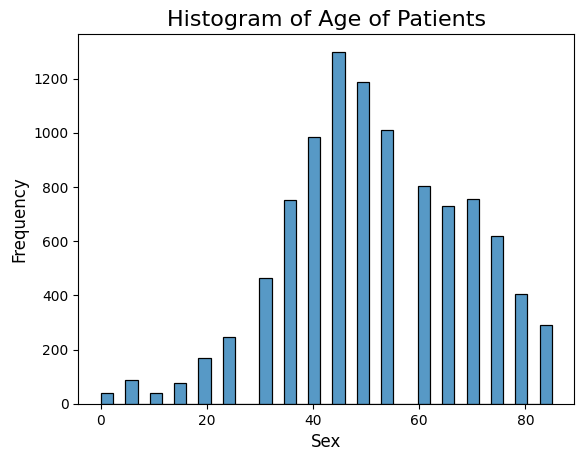

In [77]:
bar, ax = plt.subplots()
sns.histplot(meta_data['age'])
plt.xlabel('Sex', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Histogram of Age of Patients', size=16)

## Distribution of Diseased Areas

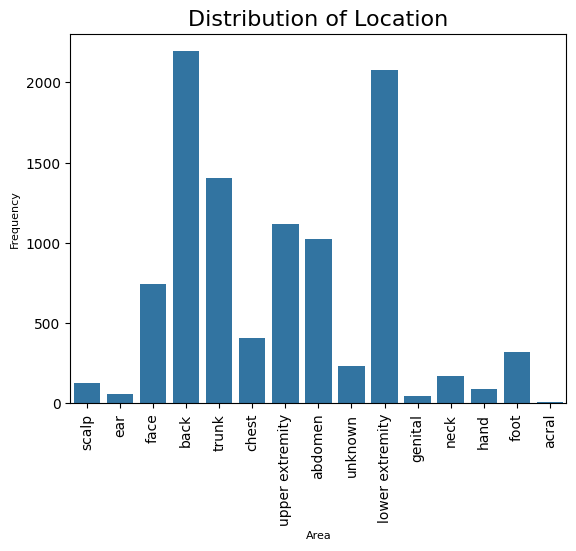

In [89]:
plt.figure()
sns.countplot(x='localization', data=meta_data)
plt.xlabel('Area', size=8)
plt.ylabel('Frequency', size=8)
plt.title('Distribution of Location', size=16)
plt.xticks(rotation=90)
plt.show()

## Distribution of Types

Text(0.5, 1.0, 'Distribution of Types')

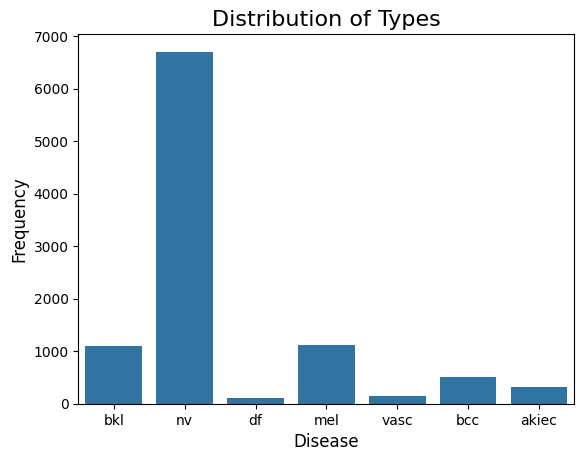

In [86]:
sns.countplot(x = 'dx', data = meta_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Distribution of Types', size=16)

## Distribution of Types over Gender

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

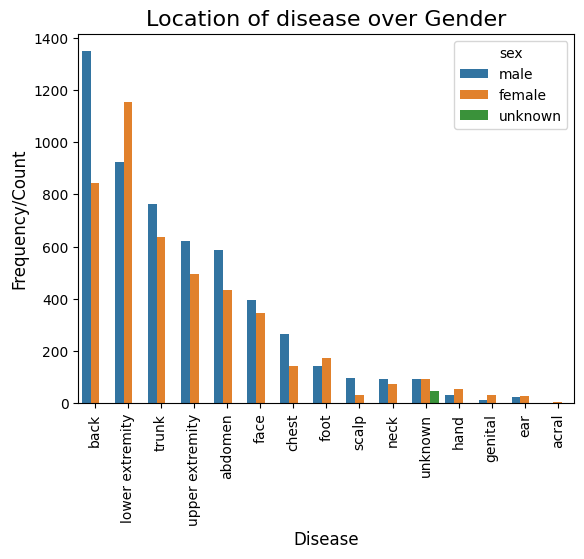

In [88]:
value = meta_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots()
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)